# Proyecto de pruebas A/B

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.


# Descripción técnica
-	**Nombre de la prueba:** recommender_system_test
-	**Grupos:** А (control), B (nuevo embudo de pago)
-	**Fecha de lanzamiento:** 2020-12-07
-	**Fecha en la que dejaron de aceptar nuevos usuarios:** 2020-12-21
-	**Fecha de finalización:** 2021-01-01
-	**Audiencia:** 15% de los nuevos usuarios de la región de la UE
-	**Propósito de la prueba:** probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
-	**Resultado esperado:** dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento product_page), instancias de agregar artículos al carrito de compras (product_cart) y compras (purchase). En cada etapa del embudo product_page → product_cart → purchase, habrá al menos un 10% de aumento.
-	**Número previsto de participantes de la prueba:** 6 000


# Descripción de los datos

1. ab_project_marketing_events_us.csv — el calendario de eventos de marketing para 2020
2. final_ab_new_users_upd_us.csv — todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
3. final_ab_events_upd_us.csv — todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
4. final_ab_participants_upd_us.csv — tabla con los datos de los participantes de la prueba


## Estructura `ab_project_marketing_events_us.csv`:

- `name`: el nombre del evento de marketing
- `regions`: regiones donde se llevará a cabo la campaña publicitaria
- `start_dt`: fecha de inicio de la campaña
- `finish_dt`: fecha de finalización de la campaña

## Estructura `final_ab_new_users_upd_us.csv`:

- `user_id`
- `first_date`: fecha de inscripción
- `region`
- `device`: dispositivo utilizado para la inscripción

## Estructura `final_ab_events_upd_us.csv`:

- `user_id`
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

## Estructura `final_ab_participants_upd_us.csv`:

- `user_id`
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenecía el usuario

# - Describe los objetivos del estudio.


## - Explora los datos:
- ¿Es necesario convertir los tipos?
- ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?

# Etapa de Preprocesamiento

In [89]:
# Importe de librerías necesarias para el proyecto:

import pandas as pd
import plotly.express as px
import seaborn as sns

from plotly import graph_objects as go
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm

In [90]:
# Cargue de los datasets a utilizar:

df1_ab_project_mark = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/ab_project_marketing_events_us.csv')
df2_ab_new_users = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/final_ab_new_users_upd_us.csv')
df3_ab_events = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/final_ab_events_upd_us.csv')
df4_ab_participants = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/final_ab_participants_upd_us.csv')

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Perfecto! Usar el link para cargar los datos asegura que cualquiera pueda reproducir el proceso de análisis sin preocuparse por que los datasets estén en la misma dirección
</div>

In [91]:
# Revisión de la estructura del primer Dataframe: 

df1_ab_project_mark.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [92]:
df1_ab_project_mark.sample(10)

,name,regions,start_dt,finish_dt
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
4,4th of July Promo,N.America,2020-07-04,2020-07-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16


Luego de la revisión del primer Dataframe `df1_ab_project_mark` podemos establecer lo siguiente:

-   Existen 14 registros en total, con 4 columnas, donde todas son de tipo `object`. No existen datos nulos en los registros (cada columna contiene 14 registros no nulos). El nombre de las columnas tienen la estructura snake_case. Las columnas name y regions serán cambiadas a tipo `Category` para obtener un [mejor procesamiento de los datos](https://pfr.com.ar/dtypes/). Por otro lado las columnas con registros de fecha (start_dt y finish_dt) serán convertidas a datetime.

In [93]:
# Revisión de la estructura del segundo Dataframe: 

df2_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [94]:
df2_ab_new_users.sample(10)

,user_id,first_date,region,device
16108,8D0A57F6E8368AFF,2020-12-21,APAC,Android
13229,C0E129D98B3D5891,2020-12-21,CIS,Android
14294,B24426D1DED28DA4,2020-12-21,N.America,Android
48480,17366D7FA47885DC,2020-12-19,N.America,Android
6059,396CAE3B1E340C85,2020-12-14,EU,Android
33477,61A36520E6EC52F3,2020-12-10,N.America,iPhone
37674,9937721809714095,2020-12-17,EU,PC
7540,8D293114A72B8668,2020-12-14,EU,iPhone
7073,AEE02C4D203A1193,2020-12-14,CIS,Android
10416,C2E00F674E860806,2020-12-14,EU,Android


Luego de la revisión del segundo Dataframe `df2_ab_new_users` podemos establecer lo siguiente:

-   Existen 58703 registros en total, con 4 columnas, donde todas son de tipo `object`. No existen datos nulos en los registros (cada columna contiene 58703 registros no nulos). El nombre de las columnas tienen la estructura snake_case. Las columnas user_id, region y device serán cambiadas a tipo `Category` para obtener un [mejor procesamiento de los datos](https://pfr.com.ar/dtypes/). Por otro lado la columna con registro de fecha (first_date) será convertida a datetime.

In [95]:
# Revisión de la estructura del primer Dataframe: 

df3_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [96]:
df3_ab_events.sample(10)

,user_id,event_dt,event_name,details
397863,9DA8023CF9EE42AF,2020-12-24 21:54:28,login,NaN
117476,39894C54091340ED,2020-12-28 10:26:51,product_cart,NaN
154115,8D31936C6E2858DF,2020-12-14 06:56:14,product_page,NaN
134322,D4329B78B953FAA2,2020-12-10 19:29:47,product_page,NaN
152806,0B4BB06B48620EF1,2020-12-14 04:40:42,product_page,NaN
409105,AF58629EAC6ED632,2020-12-26 09:30:42,login,NaN
398149,F8F6ECD9F9F00AEF,2020-12-24 04:18:40,login,NaN
147072,70B2783F3432E81F,2020-12-13 17:20:29,product_page,NaN
73422,30449A5BCDAC762E,2020-12-13 00:26:04,product_cart,NaN
384384,4A0C127CA8708875,2020-12-23 06:19:11,login,NaN


Luego de la revisión del tercer Dataframe `df3_ab_events` podemos establecer lo siguiente:

- Existen 423761 registros en total, con 4 columnas, donde todas son de tipo `object` salvo la última columna `details` que es de tipo float64. En este caso `details` sí contiene muchísimos datos nulos (más de 300 mil), por ende debe definirse posteriormente como tratar dichos nulos. El nombre de las columnas tienen la estructura snake_case. Las columnas user_id y event_name serán cambiadas a tipo `Category` para obtener un [mejor procesamiento de los datos](https://pfr.com.ar/dtypes/). Por otro lado la columna con registro de fecha (event_dt) será convertida a datetime.

In [97]:
# Revisión de la estructura del cuarto Dataframe: 

df4_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [98]:
df4_ab_participants.sample(10)

,user_id,group,ab_test
2012,F540E917082B3F70,A,recommender_system_test
9857,DFFB4F3905881D6B,B,interface_eu_test
6109,DF7C1D368B5359B2,B,interface_eu_test
3199,198FEF39910DCF76,A,recommender_system_test
1352,6DB2AB2869590A63,B,recommender_system_test
13432,AF199ED3ED55ECD1,B,interface_eu_test
7072,305AFF7F49CC1085,B,interface_eu_test
7327,3E7A039F169B02DB,A,interface_eu_test
13619,28F350E59A67F7EB,A,interface_eu_test
5782,BF353E8CDCBB1B7C,A,interface_eu_test


Luego de la revisión del cuarto Dataframe `df4_ab_participants` podemos establecer lo siguiente:

-  Existen 14525 registros en total, con 3 columnas, donde todas son de tipo `object`. No existen datos nulos en los registros (cada columna contiene 14525 registros no nulos). El nombre de las columnas tienen la estructura snake_case. Las columnas user_id, group y ab_test serán cambiadas a tipo `Category` para obtener un [mejor procesamiento de los datos](https://pfr.com.ar/dtypes).

## Conversión del tipo de datos

In [99]:
#Conversión del tipo de datos para las columnas de cada Dataframe:

# Conversión en df1_ab_project_mark:
df1_ab_project_mark['name'] = df1_ab_project_mark['name'].astype('category')
df1_ab_project_mark['regions'] = df1_ab_project_mark['regions'].astype('category')
df1_ab_project_mark['start_dt'] = pd.to_datetime(df1_ab_project_mark['start_dt'])
df1_ab_project_mark['finish_dt'] = pd.to_datetime(df1_ab_project_mark['finish_dt'])

display(df1_ab_project_mark.info())

# Conversión en df2_ab_new_users:
df2_ab_new_users['user_id'] = df2_ab_new_users['user_id'].astype('category')
df2_ab_new_users['region'] = df2_ab_new_users['region'].astype('category')
df2_ab_new_users['device'] = df2_ab_new_users['device'].astype('category')
df2_ab_new_users['first_date'] = pd.to_datetime(df2_ab_new_users['first_date'])

display(df2_ab_new_users.info())

# Conversión en df3_ab_events:
df3_ab_events['user_id'] = df3_ab_events['user_id'].astype('category')
df3_ab_events['event_name'] = df3_ab_events['event_name'].astype('category')
df3_ab_events['event_dt'] = pd.to_datetime(df3_ab_events['event_dt'])

display(df3_ab_events.info())

# Conversión en df4_ab_participants:
df4_ab_participants['ab_test'] = df4_ab_participants['ab_test'].astype('category')
df4_ab_participants['group'] = df4_ab_participants['group'].astype('category')
df4_ab_participants['user_id'] = df4_ab_participants['user_id'].astype('category')

display(df4_ab_participants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     category      
 1   regions    14 non-null     category      
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: category(2), datetime64[ns](2)
memory usage: 1.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  category      
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  category      
 3   device      58703 non-null  category      
dtypes: category(3), datetime64[ns](1)
memory usage: 3.2 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  category      
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  category      
 3   details     60314 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(1)
memory usage: 11.0 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   user_id  14525 non-null  category
 1   group    14525 non-null  category
 2   ab_test  14525 non-null  category
dtypes: category(3)
memory usage: 679.7 KB


None

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy buen trabajo con la transformación de datos y revisando los datos ausentes, un dataset limpio es clave para una buena toma de decisiones en un experimento.
</div>

## Revisión de datos nulos

Como lo mencionamos en la revisión previa, el único caso de columnas nulas es df3_ab_events['details']. Utilizaremos como criterio la mediana de los registros en dicha columna para evitar los sesgos en los resultados estadísticos

In [100]:
# Revisión de datos nulos caso df3_ab_events['details']:

df3_ab_events['details'] = df3_ab_events['details'].fillna(df3_ab_events['details'].median())

df3_ab_events['details'].describe()

count    423761.000000
mean          7.678792
std          28.037349
min           4.990000
25%           4.990000
50%           4.990000
75%           4.990000
max         499.990000
Name: details, dtype: float64

## Revisión de datos duplicados

In [101]:
# Revisión de datos duplicados en cada Dataframe:

# Revisión en dataframe df1_ab_project_mark:
print(df1_ab_project_mark.duplicated().sum())

# Revisión en dataframe df2_ab_new_users:
print(df2_ab_new_users.duplicated().sum())

# Revisión en dataframe df3_ab_events:
print(df3_ab_events.duplicated().sum())

# Revisión en dataframe df4_ab_participants:
print(df4_ab_participants.duplicated().sum())

0
0
0
0


No existen datos duplicados en los dataframes.

# Análisis exploratorio de datos (EDA):

- Lleva a cabo el análisis exploratorio de datos:
    - Estudia la conversión en las diferentes etapas del embudo.
    - ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?
    - ¿Hay usuarios que están presentes en ambas muestras?
    - ¿Cómo se distribuye el número de eventos entre los días?
    - ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

In [102]:
# Antes de proceder con el análisis, es necesario definir un nuevo Dataframe que contenga los usuarios por eventos y por el grupo de prueba al cual está asociado el usuario.
# Es por ello que uniremos los dataframes df3_ab_events y df4_ab_participants en un nuevo dataframe para obtener dicha información:

df5_ab_events_participants = df3_ab_events.merge(df4_ab_participants, on='user_id', how='inner')

df5_ab_events_participants.head()

,user_id,event_dt,event_name,details,group,ab_test
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test
1,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test
2,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,A,interface_eu_test
3,354D653172FF2A2D,2020-12-07 15:45:11,purchase,4.99,A,interface_eu_test
4,7FCD34F47C13A9AC,2020-12-07 22:06:13,purchase,9.99,B,interface_eu_test


In [103]:
print(df5_ab_events_participants.isna().sum())
print()
print(len(df5_ab_events_participants))

user_id       0
event_dt      0
event_name    0
details       0
group         0
ab_test       0
dtype: int64

102838


<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Por favor revisa el `how` del merge si quieres tratar los datos de esta forma, el outer está tomando datos que no estén en común entre los datasets, por eso obtenes tantos NaN. Para una prueba AB lo importante es capturar las métricas para los usuarios que están en los tratamientos no para los que no lo están
</div>

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> 
Ya fue corregido, se usa how='inner' y se obtienen sólo los grupo A y B <a class=“tocSkip”></a>
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Los datos que tienes ya están correctamente generados para determinar a que grupo pertenece cada usuario, no es necesario que agregues nuevos grupos ya que esto alterará tus métricas además que como puedes leer en la descripción del proyecto solo hay dos grupos para este experimento, no 3
</div>

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> 
Ya fue corregido, se elimina la creación de un nuevo grupo <a class=“tocSkip”></a>
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor (2da Iteracion)</b> <a class=“tocSkip”></a>

Buen trabajo con la corrección!
</div>

In [104]:
events_per_group = df5_ab_events_participants['group'].value_counts()
display(events_per_group)

group
A    58705
B    44133
Name: count, dtype: int64

58705 eventos pertenecen al grupo de prueba A, 44133 pertenecen al grupo de prueba B.

In [105]:
# Ahora revisaremos el número de eventos en los registros del dataframe df5_ab_events_participants:
total_events = len(df5_ab_events_participants)
print('El total de eventos es de:', total_events)

El total de eventos es de: 102838


In [106]:
# El número de usuarios únicos en los registros que registraron eventos:

unique_users = df5_ab_events_participants['user_id'].nunique()
print('El número de usuarios únicos es de:', unique_users, 'usuarios')

El número de usuarios únicos es de: 13638 usuarios


Con la información anterior, podemos ver cual es el número promedio de eventos por usuario

In [107]:
# Promedio de eventos por usuario:
avg_events_per_user = total_events / unique_users
print('El promedio de eventos por usuarios es de {:.2f}'.format(avg_events_per_user), 'eventos por usuario')

El promedio de eventos por usuarios es de 7.54 eventos por usuario


Ahora procederemos cuales son los periodos de tiempo que comprenden los datos.

In [108]:
# Registraremos sólo las fechas (sin registro de hora) en una nueva columna 'event_date':
df5_ab_events_participants['event_date'] = df5_ab_events_participants['event_dt'].dt.date # ---> Adición de columna con registro en formato fecha

# Revisión de los límites mínimos y máximos de fechas (para definier el periodo de tiempo que comprenden los datos):
min_date = df5_ab_events_participants['event_date'].min()
max_date = df5_ab_events_participants['event_date'].max()

print('El periodo de tiempo que comprenden los datos va desde', min_date, 'hasta', max_date)

El periodo de tiempo que comprenden los datos va desde 2020-12-07 hasta 2020-12-30


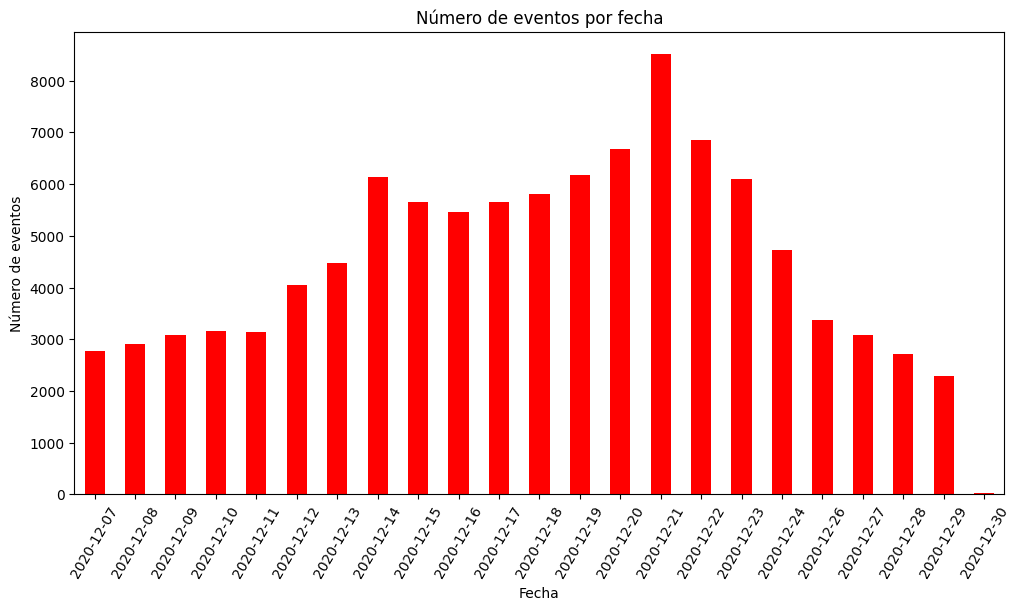

In [109]:
# ¿Cómo se distribuye el número de eventos entre los días?:

events_period_time_distribution = df5_ab_events_participants['event_date'].value_counts().sort_index()

# Histograma por fecha desde 07-12-2020 al 30-12-2020:
plt.figure(figsize=(12, 6))
df5_ab_events_participants['event_date'].value_counts().sort_index().plot(kind='bar', color='red')
plt.title('Número de eventos por fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=60)
plt.show()

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Verifica los datos que se están pasando a esta parte ya que hay un error en su ejecución
</div>

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> 
Ya fue corregido, se corrige el código usando matplotlib <a class=“tocSkip”></a>
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor (2da Iteracion)</b> <a class=“tocSkip”></a>

Buen trabajo con la corrección!
</div>

## Resultados obtenidos hasta el momento:

Hasta ahora podemos resumir que:

- **El total de eventos en los registros es de:** 102838, distribuidos así:
    - **Grupo A:** 58705 eventos
    - **Grupo B:** 44133 eventos

- **El número de usuarios únicos en los registros es de:** 13638
- **El promedio de eventos por usuario:** Un aproximado de 7.54 eventos por usuario
- **El periodo de tiempo que comprende los datos:** Van desde el 7 de Diciembre de 2020 hasta el 30 de Diciembre de 2020.

- **Del Histograma podemos concluir que:** Los eventos fueron en constante crecimiento, experimentando leves bajas en actividad llegando al pico máximo de eventos el 21 de diciembre para terminar llegando al pico mínimo de eventos el 30 de diciembre de 2020.

Ahora para proceder con el análsis del embudo, será necesario definir como es la frecuencia por evento. De la misma manera, será necesario como es el comportamiento de los eventos por usuario.

In [110]:
# Cálculo de la frecuencia de actividad por eventos:

events_frequency = df5_ab_events_participants['event_name'].value_counts()
display(events_frequency)

# Encontrar la cantidad de usuarios por evento:
users_per_event = df5_ab_events_participants.groupby('event_name')['user_id'].nunique()
display(users_per_event.sort_values(ascending=False))

#Proporción de usuarios por evento
user_proportion_per_event = users_per_event / unique_users # ---> Reutilizaremos la variable unique_users definida previamente
display(user_proportion_per_event.sort_values(ascending=False))

event_name
login           44705
product_page    28961
purchase        14854
product_cart    14318
Name: count, dtype: int64

C:\Users\c_ort\AppData\Local\Temp\ipykernel_21440\1544397116.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



event_name
login           13636
product_page     8923
purchase         4563
product_cart     4394
Name: user_id, dtype: int64

event_name
login           0.999853
product_page    0.654275
purchase        0.334580
product_cart    0.322188
Name: user_id, dtype: float64

## Conclusiones sobre la frecuencia y proporción de usuarios por evento:

- **login**: El total de ingresos (`login`) fue de 44705, de los cuales 13636 usuarios distintos registraron este evento. Dicho evento, en proporción por usuario, fue realizado el 99.99 % de las veces.
- **product_page**: El total de interacciones con `product_page` fue de 28961, de los cuales 8923 usuarios distintos registraron este evento. Dicho evento, en proporción por usuario, fue realizado el 65.43 % de las veces.
- **purchase**: El total de eventos de `purchase` fue de 14854, de los cuales 4563 usuarios distintos registraron este evento. Dicho evento, en proporción por usuario, fue realizado el 33.49 % de las veces.
- **product_cart**: La frecuencia de uso del carrito de compras (`product_cart`) fue de 14318, de los cuales 4394 usuarios distintos registraron este evento. Dicho evento, en proporción por usuario, fue realizado el 32.22 % de las veces.

## Definir la secuencia de los eventos

Las conclusiones anteriores nos pueden dar una idea de la secuencia que siguen los usuarios para los eventos. En este caso, es necesario definir la secuencia de los eventos en función de como los usuarios interactúan con dichas etapas y la proporción de usuarios que pasan de una etapa a otra (definir el embudo).

In [111]:
# Lista para definir la secuencia de los eventos:
events_sequence = ['login', 'product_page', 'product_cart', 'purchase']

# Cálculo de la cantidad de usuarios que completan cada etapa a través de un bucle for:
user_counts = [users_per_event[event] for event in events_sequence]
print(user_counts)


[13636, 8923, 4394, 4563]


In [112]:
#Calcular la proporción de usuarios que pasan de una etapa a la siguiente a través de recorrer user_counts:

conversion_rates = []

"""En el siguiente bucle se recorrerán 3 eventos 
    donde se calculará la proporción entre la cantidad
    de usuarios de un evento respecto al anterior   
"""

for i in range(len(user_counts) - 1):
    conversion_rate = user_counts[i + 1] / user_counts[i]      
    conversion_rates.append(conversion_rate)

print(conversion_rates)

[0.6543707832208859, 0.4924352796144794, 1.0384615384615385]


In [113]:
# Finalmente se calcula la proporción de usuarios que hacen el recorrido por todos los eventos (recorren todo el embudo):
total_conversion_rate = user_counts[-1] / user_counts[0]
print(total_conversion_rate)

0.33462892343795836


Ahora procederemos a procesar gráficamente los resultados obtenidos.

In [114]:
# Almacenar los resultados en un nuevo DataFrame para el embudo de eventos:
events_funnel = pd.DataFrame({'event': events_sequence, 'users': user_counts})
display(events_funnel)

# Gráfico de funnel:
fig = go.Figure(go.Funnel(
    y = events_sequence,
    x = events_funnel['users']
    ))
fig.show()

,event,users
0,login,13636
1,product_page,8923
2,product_cart,4394
3,purchase,4563


## Conclusiones del embudo de eventos:

- **login**: 13636 usuarios distintos registraron este evento. Desde este primer evento a la etapa de final de compra llega un 33.5% de los usuarios.
- **product_page**: 8923 usuarios distintos registraron este evento. En proporción a la etapa inicial 65.4 % de los usuarios son los que llegan a esta etapa.
- **product_cart**: 4394 usuarios distintos registraron este evento. 49.2% de los usuarios que estuvieron anteriormente en `product_page` llegan a esta etapa y 32.2% respecto a `login`.
- **purchase**: Finalmente 4563 usuarios distintos registraron este evento. 103.8% respecto a `product_cart`, es probable que algunos usuarios hayan interactuado con este evento sin previamente haber pasado por el carrito de compras.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy bien hecho! La visualización es correcta para este caso 
</div>

# Evaluación de la prueba A/B

## Definir los usuarios para cada grupo

In [115]:
# Inicialmente necesitaremos filtrar los datos por los grupos de control y prueba:
group_A = df5_ab_events_participants[df5_ab_events_participants['group'] == 'A']
group_B = df5_ab_events_participants[df5_ab_events_participants['group'] == 'B']

# Contar usuarios únicos que realizaron la prueba (sólo usuarios pertenecientes a los grupos A y B):
total_users_A = group_A['user_id'].nunique()
total_users_B = group_B['user_id'].nunique()

print('Total de usuarios que pertenecen al grupo A:', total_users_A)
print('Total de usuarios que pertenecen al grupo B:', total_users_B)

Total de usuarios que pertenecen al grupo A: 7874
Total de usuarios que pertenecen al grupo B: 6205


In [126]:
# Ahora necesitamos resumir como se distribuyen los usuarios en cada evento para cada grupo:
summary = df5_ab_events_participants.groupby(['group', 'event_name']).agg({'user_id': 'nunique'}).reset_index()
summary_pivot = summary.pivot(index='event_name', columns='group', values='user_id').reset_index()

display(summary_pivot)

C:\Users\c_ort\AppData\Local\Temp\ipykernel_21440\4081049815.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



group,event_name,A,B
0,login,7873,6204
1,product_cart,2483,2037
2,product_page,5208,3986
3,purchase,2682,2008


In [127]:
# Calculamos las tasas de conversión para cada grupo:
summary_pivot['conversion_A'] = summary_pivot['A'] / total_users_A
summary_pivot['conversion_B'] = summary_pivot['B'] / total_users_B

display(summary_pivot)

group,event_name,A,B,conversion_A,conversion_B
0,login,7873,6204,0.999873,0.999839
1,product_cart,2483,2037,0.315342,0.328284
2,product_page,5208,3986,0.661417,0.642385
3,purchase,2682,2008,0.340615,0.323610


In [128]:
# Calcular diferencias en tasas de conversión y el incremento esperado del 10% (según lo planteado en el resultado esperado):
summary_pivot['difference'] = summary_pivot['conversion_B'] - summary_pivot['conversion_A']
summary_pivot['expected_increase'] = summary_pivot['conversion_A'] * 0.10

display(summary_pivot)

group,event_name,A,B,conversion_A,conversion_B,difference,expected_increase
0,login,7873,6204,0.999873,0.999839,-0.000034,0.099987
1,product_cart,2483,2037,0.315342,0.328284,0.012942,0.031534
2,product_page,5208,3986,0.661417,0.642385,-0.019032,0.066142
3,purchase,2682,2008,0.340615,0.323610,-0.017005,0.034061


In [129]:
# Finalmente realizaremos la prueba de proporciones para cada evento:
for event in summary_pivot['event_name']:
    count_A = summary_pivot[summary_pivot['event_name'] == event]['A'].values[0]
    count_B = summary_pivot[summary_pivot['event_name'] == event]['B'].values[0]
    
    z_stat, p_val = sm.stats.proportions_ztest([count_A, count_B], [total_users_A, total_users_B])
    summary_pivot.loc[summary_pivot['event_name'] == event, 'z_stat'] = z_stat
    summary_pivot.loc[summary_pivot['event_name'] == event, 'p_val'] = p_val
    
display(summary_pivot)

group,event_name,A,B,conversion_A,conversion_B,difference,expected_increase,z_stat,p_val
0,login,7873,6204,0.999873,0.999839,-0.000034,0.099987,0.168851,0.865914
1,product_cart,2483,2037,0.315342,0.328284,0.012942,0.031534,-1.632980,0.102473
2,product_page,5208,3986,0.661417,0.642385,-0.019032,0.066142,2.355363,0.018505
3,purchase,2682,2008,0.340615,0.323610,-0.017005,0.034061,2.125334,0.033559


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy buen trabajo! Siempre es bueno revisar por cada parte del embudo si hay algún cambio estadísticamente significativo
</div>

## Interpretación de Resultados:

Valores p para los grupos A, B:

* product_page: **p_val** = 0.018505
* product_cart: **p_val** = 0.102473
* purchase: **p_val** = 0.033559

La prueba no mostró un aumento del 10% en las tasas de conversión para ninguno de los eventos del embudo (product_page, product_cart, purchase).

## Recomendaciones:
1. Realizar más iteraciones de pruebas para afinar el sistema de recomendaciones.
2. Explorar otros factores que pueden estar influyendo en las tasas de conversión.
3. Considerar mejoras adicionales en el sistema de recomendaciones y re-evaluar con una nueva prueba A/B.

<div class="alert alert-block alert-info">
<b>Comentario general (1ra Iteracion)</b> <a class=“tocSkip”></a>

Hiciste un trabajo muy bueno Christian, solo que hay una parte donde hubo una confusión para los grupos que debes analizar ya que creaste otro grupo más lo cual luego afecta el resto de métricas.
    
Te he dejado algunos comentarios en esas partes para que puedas realizar las correcciones y aplicar de nuevo las pruebas de hipótesisis y demás.
    
    
Saludos.
</div>

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> 
Las correcciones fueron realizadas y hecha una nueva prueba de hipótesis para los grupos <a class=“tocSkip”></a>
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor (2da Iteracion)</b> <a class=“tocSkip”></a>

Muy bien hecho! Ahora obtuviste otros resultados ya que aplicaste las pruebas de hipótesis sobre los datos correctos
</div>